# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.out_layer(x2, activation=1)


    return x3

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    y_pred_argmax = tf.argmax(y_pred, axis=1)
    y_true_cast = tf.cast(y_true, tf.int64)

    # Порівняння y_pred з y_true
    correct_predictions = tf.equal(y_pred_argmax, y_true_cast)

    # Знаходження середньої точності 
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Training step: {step}, loss: {loss:.4f}, accuracy: {acc:.4f}")

Training step: 100, loss: 335.8466, accuracy: 0.6719
Training step: 200, loss: 225.6522, accuracy: 0.7383
Training step: 300, loss: 174.2234, accuracy: 0.8047
Training step: 400, loss: 175.2688, accuracy: 0.8516
Training step: 500, loss: 171.9912, accuracy: 0.8359
Training step: 600, loss: 161.6163, accuracy: 0.8047
Training step: 700, loss: 91.9465, accuracy: 0.9023
Training step: 800, loss: 145.0899, accuracy: 0.8359
Training step: 900, loss: 95.8254, accuracy: 0.9023
Training step: 1000, loss: 95.9397, accuracy: 0.8750
Training step: 1100, loss: 113.3781, accuracy: 0.8906
Training step: 1200, loss: 99.8196, accuracy: 0.8828
Training step: 1300, loss: 116.2426, accuracy: 0.8672
Training step: 1400, loss: 95.8380, accuracy: 0.9180
Training step: 1500, loss: 66.1934, accuracy: 0.9336
Training step: 1600, loss: 99.3109, accuracy: 0.9062
Training step: 1700, loss: 66.3795, accuracy: 0.8984
Training step: 1800, loss: 98.9237, accuracy: 0.8945
Training step: 1900, loss: 63.5466, accuracy: 

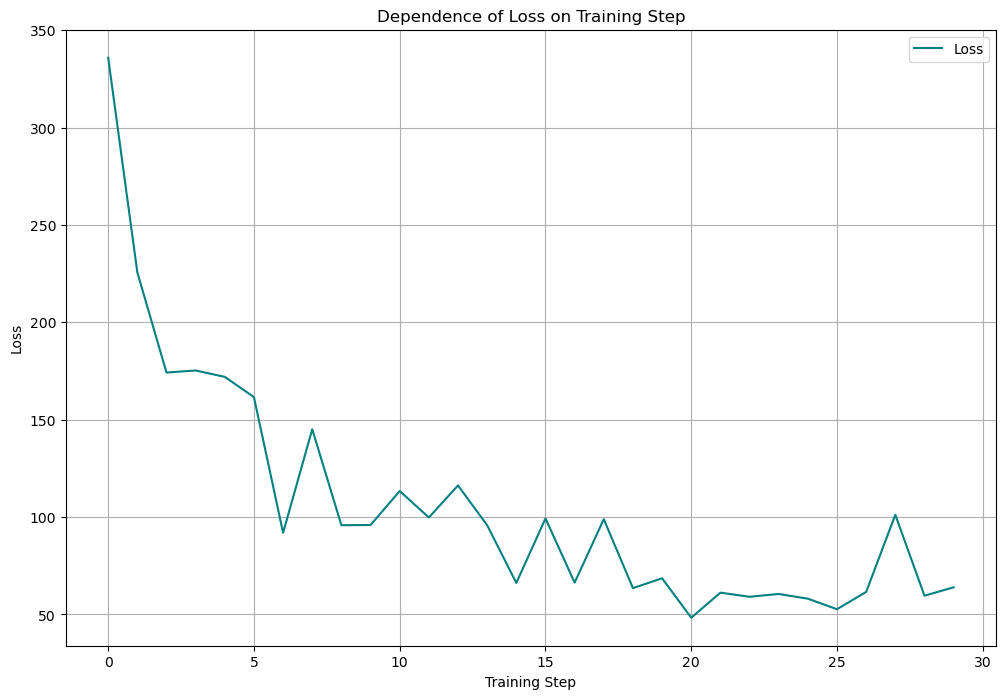

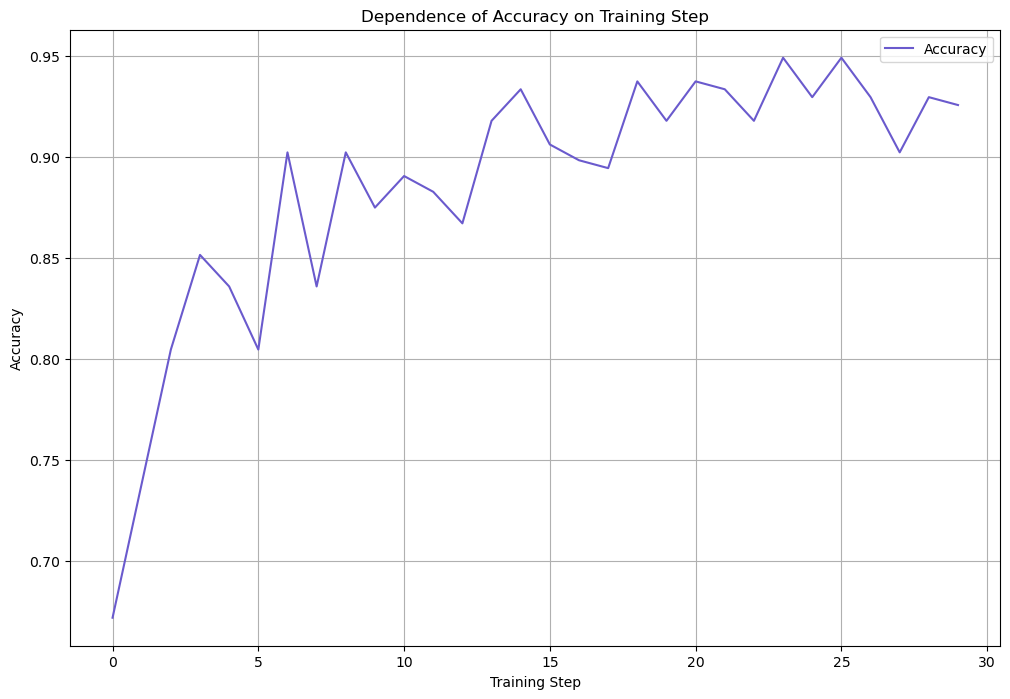

In [9]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 8))
plt.plot(loss_history, label='Loss', color="teal")
plt.title('Dependence of Loss on Training Step')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(12, 8))
plt.plot(accuracy_history, label='Accuracy', color="slateblue")
plt.title('Dependence of Accuracy on Training Step')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Обчисліть точність навченої нейромережі
pred_train = neural_net(x_train)
accuracy_train_data = accuracy(pred_train, y_train)
print(f"Accuracy on Training data: {accuracy_train_data}")

# Тестування моделі на тестових даних
pred_test = neural_net(x_test)
accuracy_test_data = accuracy(pred_test, y_test)
print(f"Accuracy on Test data: {accuracy_test_data}")

Accuracy on Training data: 0.9265000224113464
Accuracy on Test data: 0.9023000001907349


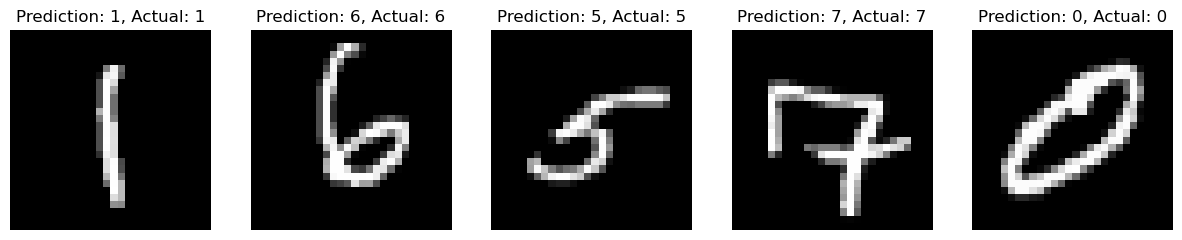

In [13]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
random_indices = np.random.choice(len(x_test), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]
prediction = neural_net(images_to_test)

# Виведіть зображення та випишіть  поруч відповідь нейромережі.
plt.figure(figsize=(15, 5))
for elem in range(5):
    plt.subplot(1, 5, elem+1)
    plt.imshow(images_to_test[elem].reshape((28, 28)), cmap='gray')
    plt.title(f"Prediction: {tf.argmax(prediction[elem], axis=0).numpy()}, Actual: {labels_to_test[elem]}")
    plt.axis('off')
plt.show()

####  Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

Нейронна мережа, навчена на базі даних MNIST, досягла досить гарної точності приблизно 90,23%. Це вказує на те, що модель добре класифікує рукописні цифри, але все таки має невеликий відсоток помилок